# 1. General (MIMIC) database analysis

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import getpass
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

In [2]:
# Database connection: information related to the previously created database
sqluser = 'postgres'
host = 'localhost'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to postgres with a copy of the MIMIC-III database 
con = psycopg2.connect(dbname=dbname, user=sqluser, host=host, 
                      password=getpass.getpass(prompt='Password:'.format(sqluser)))

# State to the adequate Schema
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema_name))

Password:········


In [3]:
# From MIMIC's Tutorial: calculation of age and designation of age-groups 

query = \
"""
WITH first_admission_time AS
(
  SELECT
      p.subject_id, p.dob, p.gender, d_icd.icd9_code, p.expire_flag
      , MIN (a.admittime) AS first_admittime
      , MIN( ROUND( (cast(admittime as date) - cast(dob as date)) / 365.242,2) )
          AS first_admit_age
  FROM patients p
  INNER JOIN admissions a
  ON p.subject_id = a.subject_id
  INNER JOIN diagnoses_icd d_icd
  ON p.subject_id = d_icd.subject_id
  GROUP BY p.subject_id, p.dob, p.gender, d_icd.icd9_code, p.expire_flag
  ORDER BY p.subject_id
)
SELECT
    f.subject_id, dob, gender, f.icd9_code, f.expire_flag
    , first_admittime, first_admit_age, did.short_title, did.long_title
    , CASE
        -- all ages > 89 in the database were replaced with 300
        WHEN first_admit_age >= 65
            THEN 'Senior'
        WHEN first_admit_age >= 40
            THEN 'Adult'
        WHEN first_admit_age >= 18
            THEN 'Young adult'
        WHEN first_admit_age >= 2
            THEN 'Child'
        WHEN first_admit_age <= 1
            THEN 'Neonate'
        ELSE 'middle'
        END AS age_group
FROM first_admission_time f
INNER JOIN d_icd_diagnoses did
ON f.icd9_code = did.icd9_code
ORDER BY f.subject_id
"""
df_nts = pd.read_sql_query(query, con)

In [4]:
df_nts.head(10)

,subject_id,dob,gender,icd9_code,expire_flag,first_admittime,first_admit_age,short_title,long_title,age_group
0,2,2138-07-17,M,V053,0,2138-07-17 19:04:00,0.00,Need prphyl vc vrl hepat,Need for prophylactic vaccination and inoculat...,Neonate
1,2,2138-07-17,M,V290,0,2138-07-17 19:04:00,0.00,NB obsrv suspct infect,Observation for suspected infectious condition,Neonate
2,2,2138-07-17,M,V3001,0,2138-07-17 19:04:00,0.00,Single lb in-hosp w cs,"Single liveborn, born in hospital, delivered b...",Neonate
3,3,2025-04-11,M,0389,1,2101-10-20 19:08:00,76.52,Septicemia NOS,Unspecified septicemia,Senior
4,3,2025-04-11,M,4275,1,2101-10-20 19:08:00,76.52,Cardiac arrest,Cardiac arrest,Senior
5,3,2025-04-11,M,4280,1,2101-10-20 19:08:00,76.52,CHF NOS,"Congestive heart failure, unspecified",Senior
6,3,2025-04-11,M,2639,1,2101-10-20 19:08:00,76.52,Protein-cal malnutr NOS,Unspecified protein-calorie malnutrition,Senior
7,3,2025-04-11,M,5849,1,2101-10-20 19:08:00,76.52,Acute kidney failure NOS,"Acute kidney failure, unspecified",Senior
8,3,2025-04-11,M,6826,1,2101-10-20 19:08:00,76.52,Cellulitis of leg,"Cellulitis and abscess of leg, except foot",Senior
9,3,2025-04-11,M,41071,1,2101-10-20 19:08:00,76.52,"Subendo infarct, initial","Subendocardial infarction, initial episode of ...",Senior


In [5]:
df_nts_a = df_nts.groupby('short_title').filter(lambda x: len(x) > 1500)

In [6]:
label_value = df_nts_a.short_title.value_counts()
len(label_value)

60

## Sample Population Analysis

Data exploration in an extensive database, such as MIMIC, constraints to perform an organized and focused analysis. Following this idea, a general demographic analysis is performed regarding age and gender to obtain some insights about the general population of the database. Then, diagnosis is selected as the main driven subject to explore the database, starting with the most common established diseases for patient's entry at the ICU to identify patterns and relevant concepts.

In [7]:
df_nts.age_group.value_counts()

Senior         288616
Adult          196109
Neonate         44459
Young adult     41478
Child             723
Name: age_group, dtype: int64

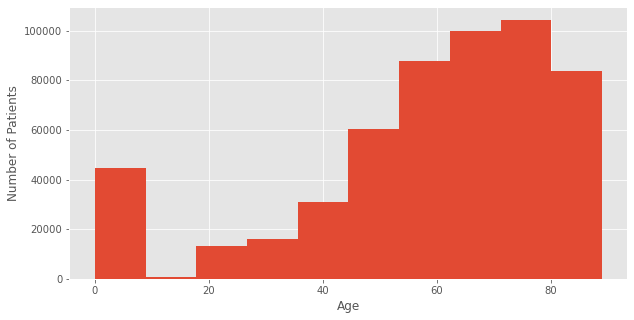

In [8]:
# Correction for age -> only patients younger than 89. Patients older than 90 years are designated as 300 years old

fig1, ax1 = plt.subplots(figsize=(10, 5))

ax1.hist(df_nts[df_nts.first_admit_age < 100].first_admit_age)
ax1.set(xlabel = "Age",
        ylabel = "Number of Patients");

Age distribution shows a small peak of neonatal patients, and then a valley during childhood and teen years that grows from the 20´s onward, peaking around ages 60-80. This trend is consistent with the fact that relevant pathological process develops through life and have major impact at certain threshold ages, due to poor lifestyle, genetic predisposition, or normal ageing processes. 

In [9]:
df_ag = df_nts.groupby(by=['age_group', 'gender']).count()
Female = df_ag.subject_id[::2].values
Male = df_ag.subject_id[1::2].values
index = ['Adult', 'Child', 'Neonate', 'Senior', 'Young Adult']
df_bar = pd.DataFrame({'Female': Female,
                       'Male': Male}, index=index)

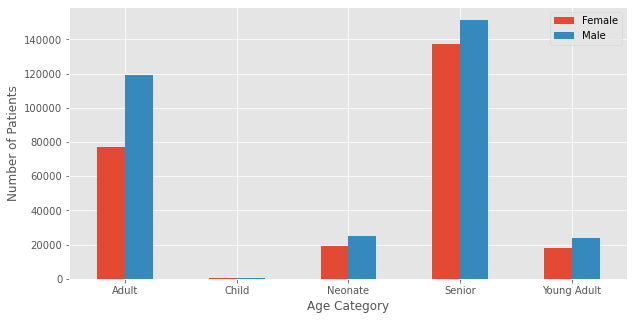

In [10]:
ax2 = df_bar.plot.bar(rot=0, figsize=(10, 5))
ax2.set(title="",
      xlabel="Age Category",
      ylabel="Number of Patients");

Grouping by gender, group ages show a consistent trend in which female patients tend to be less prone to ICU entry. This could be due to social roles, a genetic or phenotypic difference, lifestyles, and many other reasons, that impact this specific sample population. To arrive to potential causal reasons, a more detailed analysis and more detailed information, such as epidemiological, demographic, economic and/or social situation, should be introduced to the analysis.

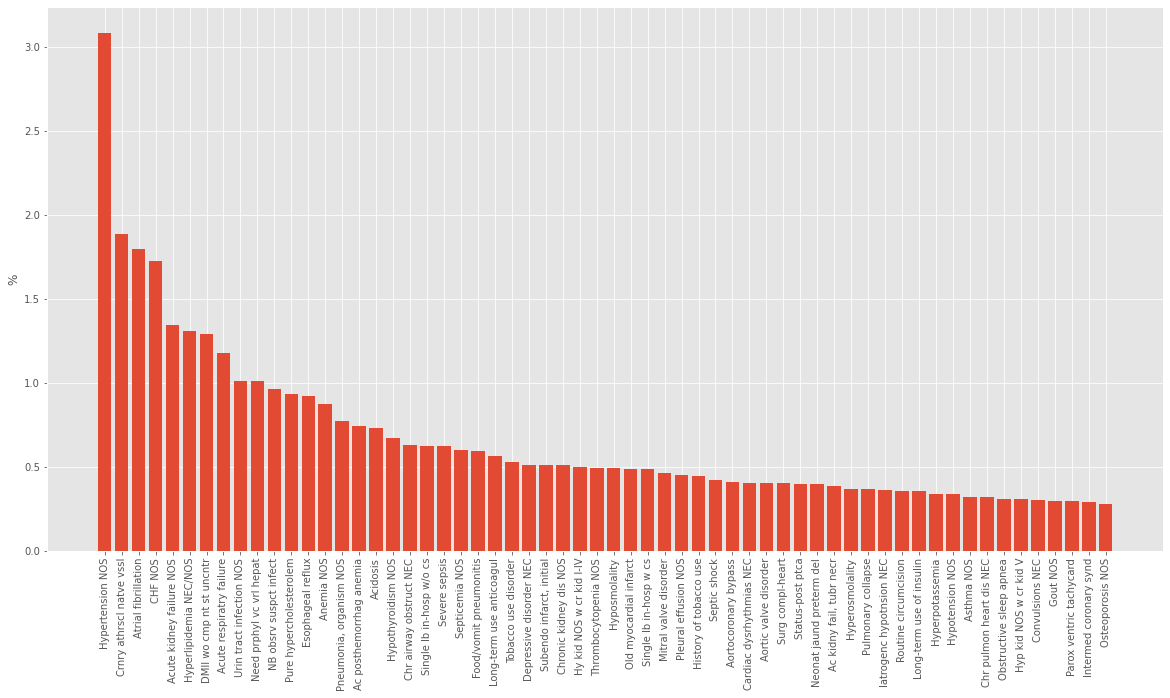

In [11]:
# Bar chart: Most common diagnosis of Patients in the database (as a percentage of total records)
labels = label_value.index
sizes = (label_value.values/len(df_nts))*100

fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(labels, sizes)
ax.set(ylabel = '%')
plt.xticks(rotation=90)

plt.show()

The bar plot shows that among the top 5 reasons for ICU patient's reception, 3 of them, including the top 1, are related to cardiovascular diseases (CVDs). Indeed, CVDs are the leading cause of deaths at worldwide level taking an estimated of 17.9 million lives each year according to the WHO [1]. 

### Heart Failure Diagnosis: subsample population
Since CVDs show an important impact in health terms for this population, the analysis will be focused on this subpopulation affected specifically by CVDs and with an specific diagnosis of Heart Failure.
Indeed, Heart failure (HF) affects about 5.1 million people in the United States only and about 23 million people worldwide. HF is responsible for a large burden of morbidity and mortality, poor quality of life, and healthcare costs [2].

In [12]:
# Selection of patients with a diagnosis that includes the expression "Heart Failure"
query = \
"""
SELECT *
FROM d_icd_diagnoses d_ic
INNER JOIN diagnoses_icd d
ON d_ic.icd9_code = d.icd9_code
WHERE long_title LIKE '%heart failure%'
"""
df_hf = pd.read_sql_query(query, con)
df_hf

,row_id,icd9_code,short_title,long_title,row_id,subject_id,hadm_id,seq_num,icd9_code
0,4300,39891,Rheumatic heart failure,Rheumatic heart failure (congestive),649,83,158569,2,39891
1,4300,39891,Rheumatic heart failure,Rheumatic heart failure (congestive),2424,195,118936,3,39891
2,4300,39891,Rheumatic heart failure,Rheumatic heart failure (congestive),2752,223,105694,5,39891
3,4300,39891,Rheumatic heart failure,Rheumatic heart failure (congestive),5499,453,187961,9,39891
4,4300,39891,Rheumatic heart failure,Rheumatic heart failure (congestive),4701,394,159229,2,39891
...,...,...,...,...,...,...,...,...,...
21284,4486,42843,Ac/chr syst/dia hrt fail,Acute on chronic combined systolic and diastol...,642612,98169,106007,2,42843
21285,4486,42843,Ac/chr syst/dia hrt fail,Acute on chronic combined systolic and diastol...,642325,98046,139402,2,42843
21286,4486,42843,Ac/chr syst/dia hrt fail,Acute on chronic combined systolic and diastol...,638530,97181,172815,2,42843
21287,4486,42843,Ac/chr syst/dia hrt fail,Acute on chronic combined systolic and diastol...,637399,96958,102063,8,42843


In [13]:
df_hf['short_title'].value_counts()

CHF NOS                     13111
Chr diastolic hrt fail       1240
Ac on chr diast hrt fail     1220
Ac on chr syst hrt fail      1143
Chr systolic hrt failure     1097
Diastolc hrt failure NOS      800
Ac systolic hrt failure       492
Rheumatic heart failure       437
Ac diastolic hrt failure      432
Systolic hrt failure NOS      416
Ac/chr syst/dia hrt fail      327
Chr syst/diastl hrt fail      179
Syst/diast hrt fail NOS       110
Hyp ht dis NOS w ht fail       82
Ac syst/diastol hrt fail       73
Hyp ht/kd NOS I-IV w hf        34
Hyp ht/kd NOS st V w hf        26
Left heart failure             23
Hyp hrt dis NOS w/o hf         16
Mal hyp ht/kd stg V w hf        8
Hy ht/kd NOS st V w/o hf        4
Mal hyp ht/kd I-IV w hf         4
Mal hypert hrt dis w hf         4
Mal hyp ht dis w/o hf           3
Hy ht/kd NOS I-IV w/o hf        3
Benign hyp ht dis w/o hf        1
Ben hyp ht/kd I-IV w hf         1
Mal hy ht/kd I-IV w/o hf        1
Benign hyp ht dis w hf          1
Ben hyp ht/kd 

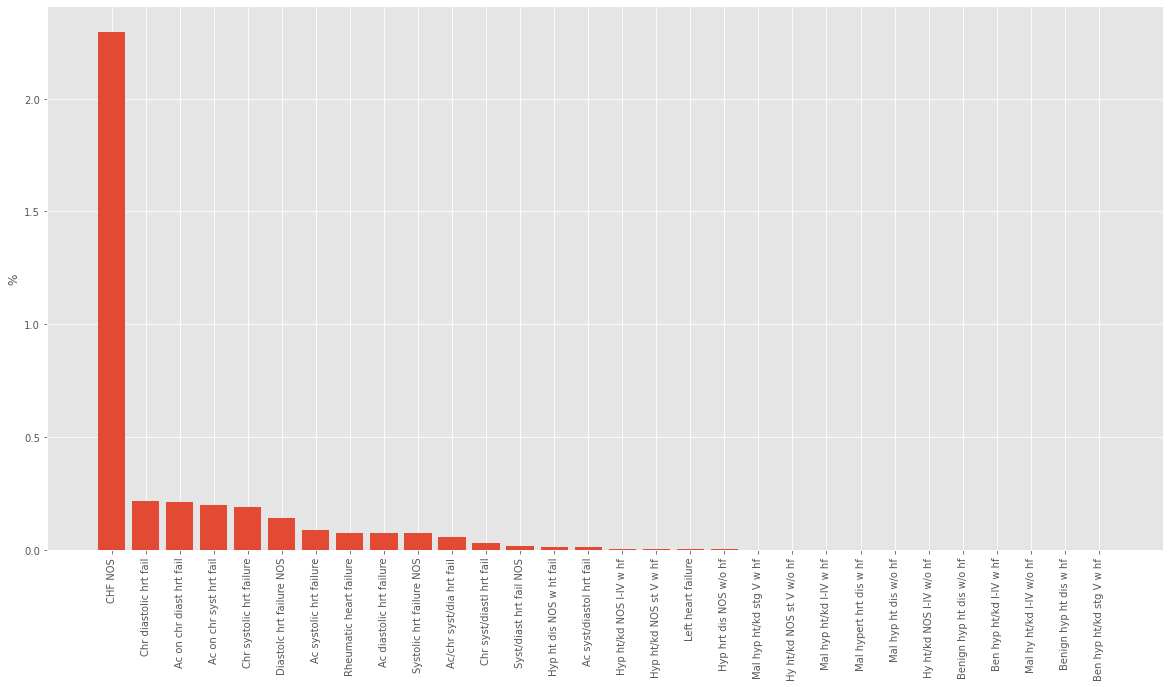

In [14]:
# Bar chart: most common diagnosis that includes the expression "Heart Failure"
labels = df_hf['short_title'].value_counts().index
sizes = (df_hf['short_title'].value_counts()/len(df_nts))*100

fig3, ax3 = plt.subplots(figsize=(20, 10))
ax3.bar(labels, sizes)
ax3.set(ylabel = '%')
plt.xticks(rotation=90)

plt.show()

The bar chart shows that Congestive Heart Failure (CHF) is by far the most common diagnosis in the selected subsample population. The following 4 diagnosis show a similar number of patients, and indicate a direct relation with systolic or diastolic heart failure. 

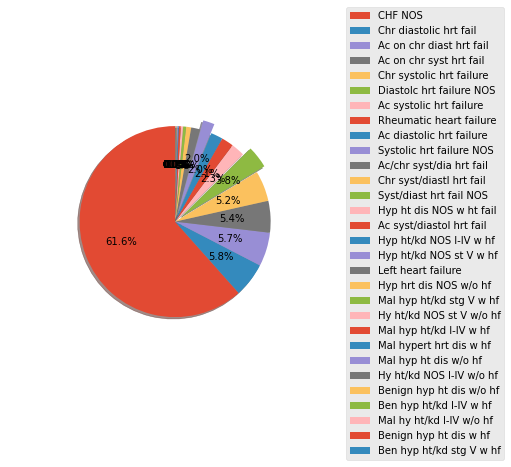

In [15]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df_hf['short_title'].value_counts().index
sizes = (df_hf['short_title'].value_counts()/len(df_nts))*100
explode = (0, 0, 0, 0, 0, 0.1,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig4, ax4 = plt.subplots()
ax4.pie(sizes, explode=explode, labels=None, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax4.legend(loc='upper right', bbox_to_anchor=(1.5, 1.5), labels=labels)

plt.show()

To complement the bar chart, this pie chart show the graphical percentage distribution of diagnosis that include the expression "Heart Failure".

### Systolic or Diastolic Heart Failure: Subsample Population
Among the diagnosis related with Heart Failure, there are many categories in which Systolic or Diastolic Heart Failure are included. These two categories represent Heart Failure subtypes, which are differentiated not only by the physiological cardiac function diminished in each case but also in their prognosis and potential treatment. Thus, even if interrelated by the complexity of the Heart Failure complex progression and multifactorial causality, the course of action could be completely diverse for each case, making a correct diagnosis a fundamental step for these patients.

In [16]:
query = \
"""
SELECT *
FROM d_icd_diagnoses
"""
df_diag = pd.read_sql_query(query, con)
df_diag

,row_id,icd9_code,short_title,long_title
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."
...,...,...,...,...
14562,14432,V7399,Scrn unspcf viral dis,Special screening examination for unspecified ...
14563,14433,V740,Screening for cholera,Screening examination for cholera
14564,14434,V741,Screening-pulmonary TB,Screening examination for pulmonary tuberculosis
14565,14435,V742,Screening for leprosy,Screening examination for leprosy (Hansen's di...


In [17]:
np.set_printoptions(threshold=np.inf)
for diagn in df_diag['long_title']:
    if 'Diastolic heart failure' in df_diag['long_title']:
        print(diagn)

In [18]:
# Identification of the diagnosis code for diastolic heart failure
df_diag[df_diag['long_title'] == 'Diastolic heart failure, unspecified']

,row_id,icd9_code,short_title,long_title
4480,4479,42830,Diastolc hrt failure NOS,"Diastolic heart failure, unspecified"


In [19]:
# Identification of the diagnosis code for systolic heart failure
df_diag[df_diag['long_title'] == 'Systolic heart failure, unspecified']

,row_id,icd9_code,short_title,long_title
4476,4475,42820,Systolic hrt failure NOS,"Systolic heart failure, unspecified"


In [20]:
# Identification of diastolic heart failure patients by diagnosis code
patients_dias_hf = df_nts[df_nts['icd9_code'] == '42830']
patients_dias_hf

,subject_id,dob,gender,icd9_code,expire_flag,first_admittime,first_admit_age,short_title,long_title,age_group
1308,148,2029-07-11,F,42830,1,2107-09-05 14:58:00,78.15,Diastolc hrt failure NOS,"Diastolic heart failure, unspecified",Senior
1343,151,1845-05-06,F,42830,1,2145-05-06 20:00:00,300.00,Diastolc hrt failure NOS,"Diastolic heart failure, unspecified",Senior
2916,309,2098-10-01,M,42830,0,2160-06-04 09:45:00,61.67,Diastolc hrt failure NOS,"Diastolic heart failure, unspecified",Adult
4780,501,2106-06-21,F,42830,1,2190-01-28 02:04:00,83.61,Diastolc hrt failure NOS,"Diastolic heart failure, unspecified",Senior
5933,627,2056-08-02,F,42830,1,2121-01-25 15:45:00,64.48,Diastolc hrt failure NOS,"Diastolic heart failure, unspecified",Adult
...,...,...,...,...,...,...,...,...,...,...
562240,97773,2119-10-26,F,42830,1,2200-12-11 10:32:00,81.13,Diastolc hrt failure NOS,"Diastolic heart failure, unspecified",Senior
563637,98159,2061-10-18,F,42830,0,2139-08-31 10:00:00,77.87,Diastolc hrt failure NOS,"Diastolic heart failure, unspecified",Senior
566124,98744,2058-01-11,M,42830,0,2127-02-24 07:15:00,69.12,Diastolc hrt failure NOS,"Diastolic heart failure, unspecified",Senior
566461,98831,2104-07-17,M,42830,0,2170-09-07 14:08:00,66.14,Diastolc hrt failure NOS,"Diastolic heart failure, unspecified",Senior


In [21]:
# Identification of systolic heart failure patients by diagnosis code
patients_sys_hf = df_nts[df_nts['icd9_code'] == '42820']
patients_sys_hf

,subject_id,dob,gender,icd9_code,expire_flag,first_admittime,first_admit_age,short_title,long_title,age_group
496,68,2132-02-29,F,42820,1,2173-12-15 16:16:00,41.79,Systolic hrt failure NOS,"Systolic heart failure, unspecified",Adult
1209,138,2083-10-23,M,42820,0,2131-10-31 08:00:00,48.02,Systolic hrt failure NOS,"Systolic heart failure, unspecified",Adult
2841,305,2052-10-24,F,42820,1,2125-04-26 11:45:00,72.50,Systolic hrt failure NOS,"Systolic heart failure, unspecified",Senior
3314,353,2089-07-23,M,42820,1,2148-06-15 11:04:00,58.90,Systolic hrt failure NOS,"Systolic heart failure, unspecified",Adult
4742,495,2106-09-23,M,42820,1,2183-05-13 15:08:00,76.64,Systolic hrt failure NOS,"Systolic heart failure, unspecified",Senior
...,...,...,...,...,...,...,...,...,...,...
545824,93838,2023-08-09,M,42820,0,2106-09-26 17:51:00,83.13,Systolic hrt failure NOS,"Systolic heart failure, unspecified",Senior
546542,94025,2100-04-30,M,42820,1,2173-01-14 13:25:00,72.71,Systolic hrt failure NOS,"Systolic heart failure, unspecified",Senior
551375,95177,2072-11-16,M,42820,0,2128-11-17 01:09:00,56.00,Systolic hrt failure NOS,"Systolic heart failure, unspecified",Adult
555196,96148,2074-01-31,M,42820,0,2142-08-25 12:12:00,68.56,Systolic hrt failure NOS,"Systolic heart failure, unspecified",Senior


In [22]:
# Demographic analysis of the selected subsample: diastolic heart failure
df_ag = patients_dias_hf.groupby(by=['age_group', 'gender']).count()
Female = df_ag.subject_id[::2].values
Male = df_ag.subject_id[1::2].values

index = ['Adult', 'Senior', 'Young Adult']
df_bar = pd.DataFrame({'Female': Female,
                       'Male': Male}, index=index)

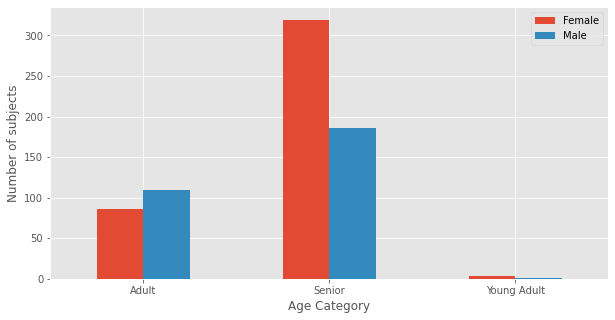

In [23]:
ax5 = df_bar.plot.bar(rot=0, figsize=(10, 5))
ax5.set(title="", 
        xlabel="Age Category",
        ylabel="Number of subjects");

In [24]:
# Demographic analysis of the selected subsample: systolic heart failure
df_ag = patients_sys_hf.groupby(by=['age_group', 'gender']).count()
Female = df_ag.subject_id[::2].values
Male = df_ag.subject_id[1::2].values
index = ['Adult', 'Senior', 'Young Adult']
df_bar = pd.DataFrame({'Female': Female,
                       'Male': Male}, index=index)

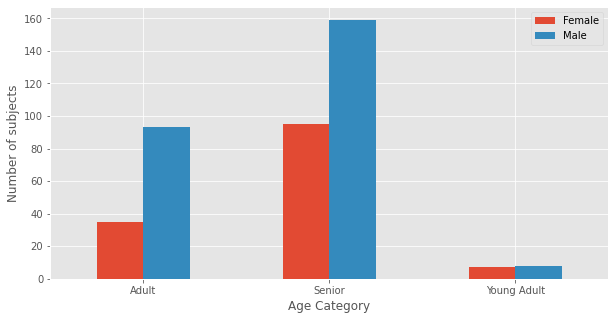

In [25]:
ax6 = df_bar.plot.bar(rot=0, figsize=(10, 5))
ax6.set(title="",
        xlabel="Age Category",
        ylabel="Number of subjects");

As expected, the selected subsample population show a higher percentage of older patients affected by these conditions, with most of the population belonging to the Senior category. An important difference between diastolic and systolic heart failure patients is the gender distribution. While systolic failure seems to be a predominantly male diagnosis, a diastolic failure diagnosis has a greater impact in older females. 

### Systolic and Diastolic Heart Failure Treatment: A comparison
Even if there are several similarities between Heart Failure subtypes, there are relevant differences that raise the importance of a differentiated treatment. Systolic Heart Failure has been treated successfully since decades ago, and evolution in terms of drug development and follow up has been important to improve prognosis and quality of life of patients. Even if these medical advances have become a starting point to diastolic failure treatment, a successful approach is still a topic of research, adding to the complexity of the disease. 

In [26]:
query = \
"""
SELECT *
FROM patients p 
INNER JOIN drgcodes drg
ON p.subject_id = drg.subject_id
INNER JOIN diagnoses_icd d_icd
ON p.subject_id = d_icd.subject_id
WHERE d_icd.icd9_code = '42830'
"""
df_drg_codes_dias = pd.read_sql_query(query, con)
df_drg_codes_dias

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,...,drg_type,drg_code,description,drg_severity,drg_mortality,row_id,subject_id,hadm_id,seq_num,icd9_code
0,290,309,M,2098-10-01,NaT,NaT,NaT,0,27972,309,...,HCFA,557,PERCUTANEOUS CARDIOVASCULAR PROCEDURE WITH NON...,NaN,NaN,3693,309,162308,2,42830
1,290,309,M,2098-10-01,NaT,NaT,NaT,0,27973,309,...,APR,1752,Percutaneous Cardiovascular Procedures w/o AMI,2.0,2.0,3693,309,162308,2,42830
2,138,148,F,2029-07-11,2109-06-06,NaT,2109-06-06,1,13004,148,...,HCFA,403,LYMPHOMA & NON-ACUTE LEUKEMIA WITH COMPLICATIO...,NaN,NaN,1862,148,199488,7,42830
3,141,151,F,1845-05-06,2148-05-27,2148-05-27,2148-05-27,1,5460,151,...,HCFA,106,CORONARY BYPASS WITH PTCA,NaN,NaN,1892,151,151029,2,42830
4,473,501,F,2106-06-21,2191-02-21,NaT,2191-02-21,1,26228,501,...,APR,1333,Pulmonary Edema & Respiratory Failure,3.0,3.0,5882,501,190462,3,42830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5202,45892,97569,F,2129-09-20,NaT,NaT,NaT,0,100940,97569,...,MS,219,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W/...,NaN,NaN,640285,97569,172362,4,42830
5203,45892,97569,F,2129-09-20,NaT,NaT,NaT,0,100736,97569,...,APR,1904,Acute Myocardial Infarction,4.0,4.0,640285,97569,172362,4,42830
5204,45892,97569,F,2129-09-20,NaT,NaT,NaT,0,100737,97569,...,APR,1904,Acute Myocardial Infarction,4.0,4.0,640285,97569,172362,4,42830
5205,45892,97569,F,2129-09-20,NaT,NaT,NaT,0,100738,97569,...,MS,280,"ACUTE MYOCARDIAL INFARCTION, DISCHARGED ALIVE ...",NaN,NaN,640285,97569,172362,4,42830


In [27]:
query = \
"""
SELECT *
FROM patients p 
INNER JOIN drgcodes drg
ON p.subject_id = drg.subject_id
INNER JOIN diagnoses_icd d_icd
ON p.subject_id = d_icd.subject_id
WHERE d_icd.icd9_code = '42820'
"""
df_drg_codes_sys = pd.read_sql_query(query, con)
df_drg_codes_sys

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,...,drg_type,drg_code,description,drg_severity,drg_mortality,row_id,subject_id,hadm_id,seq_num,icd9_code
0,61,68,F,2132-02-29,2174-02-11,NaT,2174-02-11,1,20693,68,...,APR,8924,HIV W Major HIV Related Condition,4.0,3.0,555,68,170467,4,42820
1,61,68,F,2132-02-29,2174-02-11,NaT,2174-02-11,1,20694,68,...,HCFA,489,HIV WITH MAJOR RELATED CONDITION,NaN,NaN,555,68,170467,4,42820
2,61,68,F,2132-02-29,2174-02-11,NaT,2174-02-11,1,25714,68,...,APR,8924,HIV W Major HIV Related Condition,4.0,4.0,555,68,170467,4,42820
3,61,68,F,2132-02-29,2174-02-11,NaT,2174-02-11,1,25715,68,...,HCFA,489,HIV WITH MAJOR RELATED CONDITION,NaN,NaN,555,68,170467,4,42820
4,286,305,F,2052-10-24,2129-09-07,2129-09-07,NaT,1,20090,305,...,HCFA,526,PERCUTANEOUS CARDIOVASCULAR PROCEDURE WITH DRU...,NaN,NaN,3596,305,122211,1,42820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016,44271,91365,M,1851-05-25,NaT,NaT,NaT,0,118623,91365,...,APR,7203,Septicemia & Disseminated Infections,3.0,4.0,611435,91365,128364,6,42820
2017,44271,91365,M,1851-05-25,NaT,NaT,NaT,0,118624,91365,...,MS,871,SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W...,NaN,NaN,611435,91365,128364,6,42820
2018,46084,98299,F,2117-11-27,2201-01-28,2201-01-28,2201-01-28,1,62986,98299,...,APR,1394,Other Pneumonia,4.0,4.0,643305,98299,112205,3,42820
2019,46084,98299,F,2117-11-27,2201-01-28,2201-01-28,2201-01-28,1,62987,98299,...,APR,1394,Other Pneumonia,4.0,4.0,643305,98299,112205,3,42820


In [28]:
print('Drug codes used for Diastolic heart failure treatment:', df_drg_codes_dias['drg_type'].unique())
print('Drug codes used for Systolic heart failure treatment:', df_drg_codes_sys['drg_type'].unique())

Drug codes used for Diastolic heart failure treatment: ['HCFA' 'APR ' 'MS']
Drug codes used for Systolic heart failure treatment: ['APR ' 'HCFA' 'MS']


In [29]:
df_drg_codes_dia = df_drg_codes_dias.groupby('drg_code').filter(lambda x: len(x) > 20)
df_drg_codes_dia['drg_code'].value_counts()

7204    189
1334    165
475     130
1943    103
127      94
       ... 
110      21
0044     21
107      21
541      21
1744     21
Name: drg_code, Length: 64, dtype: int64

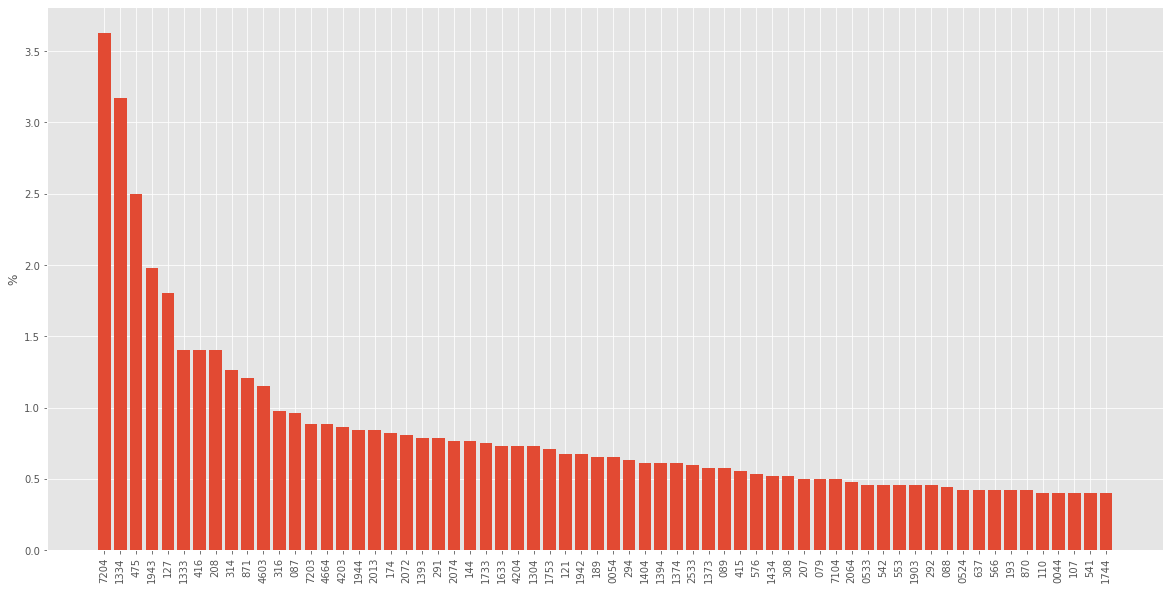

In [30]:
# Bar chart: Drug codes for diastolic heart failure treatment
labels = df_drg_codes_dia['drg_code'].value_counts().index
sizes = (df_drg_codes_dia['drg_code'].value_counts()/len(df_drg_codes_dias['drg_code']))*100

fig3, ax3 = plt.subplots(figsize=(20, 10))
ax3.bar(labels, sizes)
ax3.set(ylabel = '%')
plt.xticks(rotation=90)

plt.show()

In [31]:
df_drg_codes_sy = df_drg_codes_sys.groupby('drg_code').filter(lambda x: len(x) > 20)
df_drg_codes_sy['drg_code'].value_counts()

7204    99
1943    39
127     33
871     33
1944    28
110     26
1633    25
291     22
105     22
174     22
1753    22
1743    21
7203    21
4603    21
Name: drg_code, dtype: int64

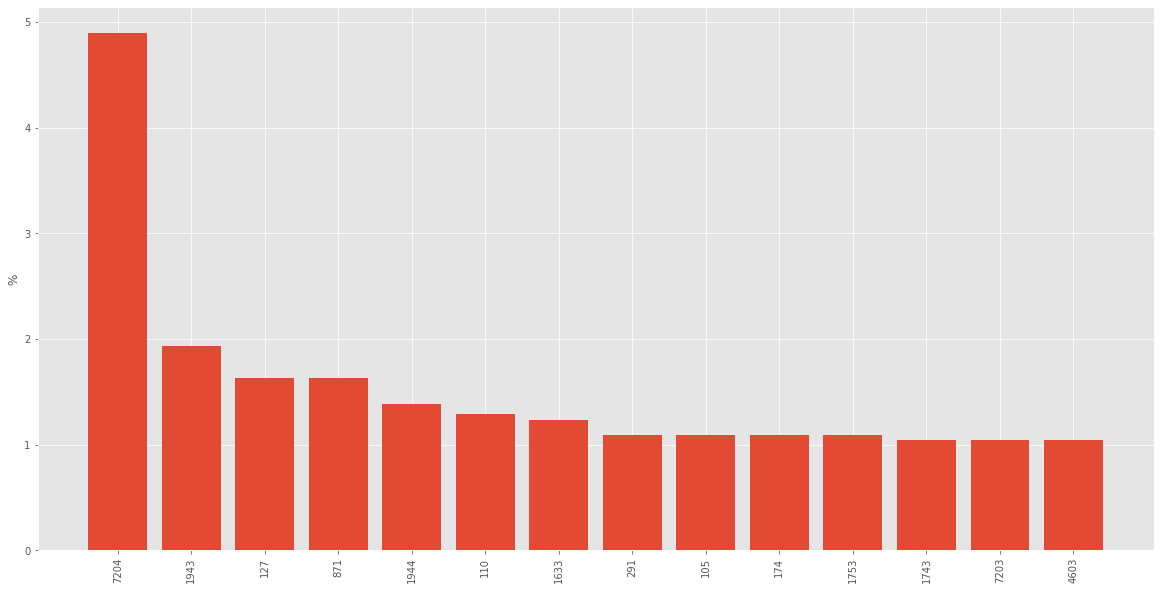

In [32]:
# Bar chart: Drug codes for systolic heart failure treatment
labels = df_drg_codes_sy['drg_code'].value_counts().index
sizes = (df_drg_codes_sy['drg_code'].value_counts()/len(df_drg_codes_sys['drg_code']))*100

fig3, ax3 = plt.subplots(figsize=(20, 10))
ax3.bar(labels, sizes)
ax3.set(ylabel = '%')
plt.xticks(rotation=90)

plt.show()

In [33]:
df_drg_codes_dias['drg_code'].value_counts()

7204    189
1334    165
475     130
1943    103
127      94
       ... 
574       1
652       1
2253      1
3214      1
111       1
Name: drg_code, Length: 587, dtype: int64

These two bar charts and additional information from the dataframe show that medicaments used for the treatment of both Heart Failure subtypes at the ICU are consistent, and that differences are not as relevant as could be expected since diastolic heart failure treatment is still a pending task in cardiovascular research.

### Systolic and Diastolic Heart Failure Outcome: A comparison of death rate
The following information indicates the percentage of deaths among the patients at the ICU with diastolic and systolic heart failure diagnosis. Diastolic failure has almost a 67% rate of deaths while systolic failure counts for almost 60%. Even if similar, this gap raise several questions, including if the mortality rate of diastolic failure is, in general, higher or if treatment is more adequate for systolic failure patients, and thus more attention is needed for diastolic failure. 

In [34]:
print((np.sum(patients_dias_hf['expire_flag'] == 1)/len(patients_dias_hf))*100)
print((np.sum(patients_sys_hf['expire_flag'] == 1)/len(patients_sys_hf))*100)

66.80851063829788
59.69773299748111


## Conclusions
The initial step of this database assessment includes a general demographic data analysis, in which age and gender show interesting patterns, for example the fact that the highest percentage of ICU patients in this MIMIC database are older males. Causality for this distribution needs a deeper analysis. Then, diagnosis is selected for analysis, building a graphical description of the most common diseases for ICU entry. Cardiovascular diseases are among the top causes for ICU entry in this population, which is consistent with the impact of CVDs worldwide. Thus, an analysis in CVD patients is performed, specifically those affected by Heart Failure subtypes: Systolic and Diastolic Heart Failure. A demographic description of patients diagnosed with either one of both subtypes show that even if older individuals are more impacted by these pathological conditions, there is a gender differentiation between them. Previous studies are consistent with these differences and in the fact that treatment should be specific. However, the database shows that the treatment for each diagnosis is almost the same at ICU level. Another differentiation level is the death rates that show around a 7% higher chance of dying at the ICU for patients with a Diastolic Hearth Failure diagnosis. Further analysis of the subsample population from the MIMIC database containing patients with a diagnosis of Diastolic and Systolic Heart Failure is performed in the following Part 2. 

### References
[1] https://www.who.int/health-topics/cardiovascular-diseases/#tab=tab_1

[2] Jain, S., Londono, F. J., Segers, P., Gillebert, T. C., De Buyzere, M., & Chirinos, J. A. (2016). Mri assessment of diastolic and systolic intraventricular pressure gradients in heart failure. Current heart failure reports, 13(1), 37-46.